## Data loading

### Subtask:
Load the data from the provided CSV file ("data.csv") into a pandas DataFrame.


              Timestamp Sender Redacted Recipients Redacted  \
0  XX/XX/2015  09:17:53     1801XXXX588               #XXX#   
1  XX/XX/2015  09:17:31     1801XXXX588               #XXX#   
2  XX/XX/2015  09:19:13     1801XXXX588               #XXX#   
3  XX/XX/2015  09:24:49     1801XXXX588               #XXX#   
4  XX/XX/2015  09:33:38     1801XXXX588               #XXX#   

               Filters SMS Message Type  \
0  suspicious filter v               MO   
1  suspicious filter v               MO   
2  suspicious filter v               MO   
3  suspicious filter v               MO   
4  suspicious filter v               MO   

                                             Preview  
0  Dice with Buddies -- just download it. http://...  
1  Dice with Buddies -- just download it. http://...  
2  Dice with Buddies -- just download it. http://...  
3  Dice with Buddies -- just download it. http://...  
4  Dice with Buddies -- just download it. http://...  
<class 'pandas.core.frame.DataFr

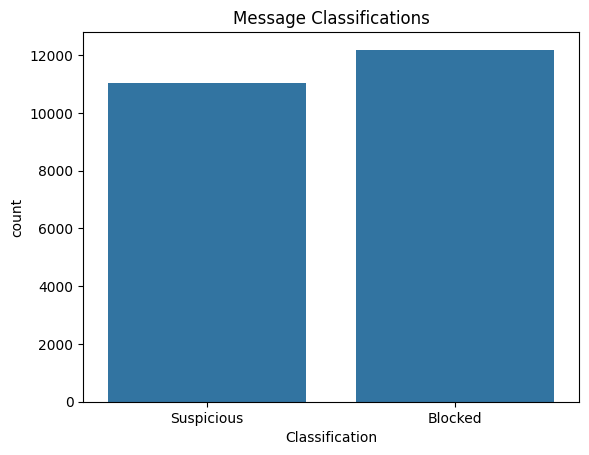

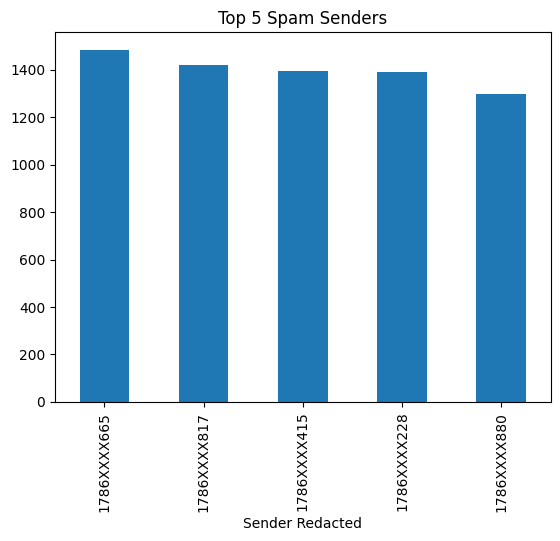

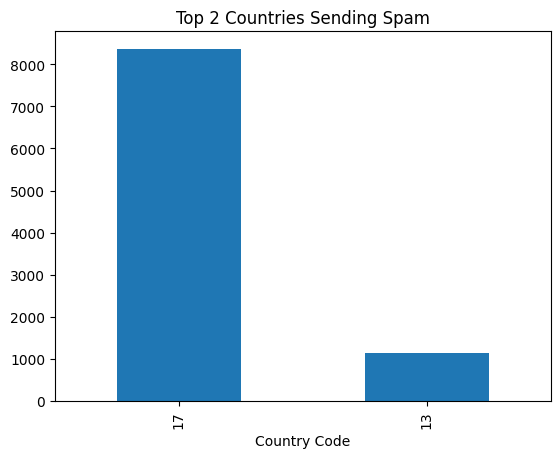

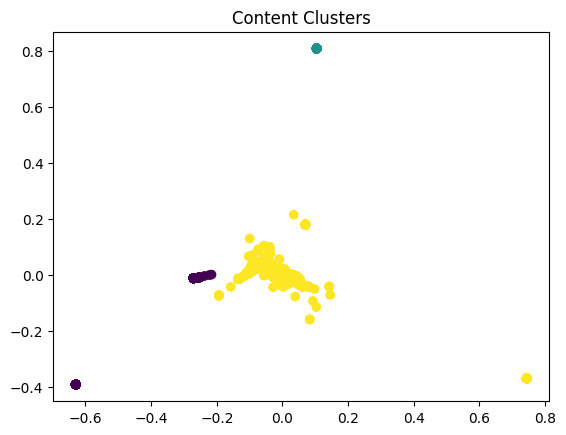

Common patterns in content:
               Pattern  Frequency
0                   to       9767
1                    I       7928
2                   is       7684
3             REDACTED       6810
4              message       5657
5                  for       5404
6                  the       4811
7                  and       4743
8                 cash       4460
9                   be       4383
10               Money       3798
11                 pay       3785
12                cars       3781
13                 3-4       3781
14             hundred       3781
15                cell       3781
16  3o5\\\\XXX\\\\XXXX       3781
17                Your       3382
18                  by       3300
19               phone       3287
Sender behavior analysis:
     Sender Redacted  Message Count  Content Cluster
0        1201XXXX019              1                2
1        1201XXXX043             16                2
2        1201XXXX145              1                2
3        1201XXXX213

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter

# Read the CSV file
df = pd.read_csv("/data.csv")

# Clean the data
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df['Filters'] = df['Filters'].str.lower()

# Data exploration
print(df.head())
print(df.info())
print(df.describe())

# Classify messages as blocked, suspicious, or none
def classify_message(filter_value):
    if 'blocking filter' in filter_value:
        return 'Blocked'
    elif 'suspicious filter' in filter_value:
        return 'Suspicious'
    else:
        return 'None'

df['Classification'] = df['Filters'].apply(classify_message)
df['Is Blocked'] = df['Classification'] == 'Blocked'
df['Is Suspicious'] = df['Classification'] == 'Suspicious'

# Count messages by classification
classification_counts = df['Classification'].value_counts()
print("Message classification counts:")
print(classification_counts)

# Count individual senders
unique_senders = df['Sender Redacted'].nunique()
print(f"Individual senders: {unique_senders}")

# Top 5 spam senders
top_senders = df[df['Classification'] == 'Blocked']['Sender Redacted'].value_counts().head(5)
print("Top 5 spam senders:")
print(top_senders)

# Unique spammers
unique_spammers = df[df['Classification'] == 'Blocked']['Sender Redacted'].nunique()
print(f"Unique spammers: {unique_spammers}")

# Top 2 countries sending spam
df['Country Code'] = df['Sender Redacted'].apply(lambda x: x[:2] if len(x) > 10 else 'NA')
top_countries = df[df['Classification'] == 'Blocked']['Country Code'].value_counts().head(2)
print("Top 2 countries sending spam:")
print(top_countries)

# Most effective blocking filters
effective_filters = df[df['Classification'] == 'Blocked']['Filters'].value_counts()
print("Most effective blocking filters:")
print(effective_filters)

# Evaluation of Suspicious Filters
suspicious_filters = df[df['Classification'] == 'Suspicious']['Filters'].value_counts()
print("Evaluation of Suspicious Filters:")
print(suspicious_filters)

# Evaluation of Blocking Filters
blocking_filters = df[df['Classification'] == 'Blocked']['Filters'].value_counts()
print("Evaluation of Blocking Filters:")
print(blocking_filters)

# Main types of spam
spam_types = df[df['Classification'] == 'Blocked']['SMS Message Type'].value_counts()
print("Main types of spam:")
print(spam_types)

# Visualization of message classifications
sns.countplot(x='Classification', data=df)
plt.title('Message Classifications')
plt.show()

# Visualization of the top 5 spam senders
top_senders.plot(kind='bar')
plt.title('Top 5 Spam Senders')
plt.show()

# Visualization of the top 2 countries sending spam
top_countries.plot(kind='bar')
plt.title('Top 2 Countries Sending Spam')
plt.show()

# Text analysis and clustering (using 'Preview' column)
if 'Preview' in df.columns:
    tfidf = TfidfVectorizer(stop_words='english', max_features=500)
    tfidf_matrix = tfidf.fit_transform(df['Preview'])
    kmeans = KMeans(n_clusters=3)
    df['Content Cluster'] = kmeans.fit_predict(tfidf_matrix)

    # Dimensionality reduction for visualization
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(tfidf_matrix.toarray())
    df['PCA1'] = reduced_data[:, 0]
    df['PCA2'] = reduced_data[:, 1]

    # Visualization of clusters
    plt.scatter(df['PCA1'], df['PCA2'], c=df['Content Cluster'], cmap='viridis')
    plt.title('Content Clusters')
    plt.show()

    # Analysis of common patterns in content
    common_patterns = Counter(" ".join(df['Preview']).split()).most_common(20)
    common_patterns_df = pd.DataFrame(common_patterns, columns=['Pattern', 'Frequency'])
    print("Common patterns in content:")
    print(common_patterns_df)

    # Sender behavior analysis
    # Create a 'Message Count' column if it doesn't exist
    if 'Message Count' not in df.columns:
        df['Message Count'] = df.groupby('Sender Redacted')['Sender Redacted'].transform('count')

    sender_behavior = df.groupby('Sender Redacted').agg({
        'Message Count': 'sum',
        'Content Cluster': lambda x: x.mode()[0]
    }).reset_index()
    print("Sender behavior analysis:")
    print(sender_behavior)
else:
    print("'Preview' column not found. Skipping text analysis and clustering.")

# Save the cleaned DataFrame to a new CSV file with additional fields
df.to_csv("cleaned_data.csv", index=False)